<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S4/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install torchsummary

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


In [3]:
cpu = torch.device("cpu")
torch.manual_seed(1)

def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def transformations(): 
  # 1. Create a tensor from the input
  return transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

def MNIST(isTrain=True, transforms=transformations()): 
  return datasets.MNIST("../data", isTrain, transform=transforms, download=True)

def dataLoader(dataset): 
  args = {'num_workers': 1, 'pin_memory': True} if isCuda() else {}
  return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, **args)

def showImages(images, labels, cols=5, figsize=(12, 10)):
  num_images = len(images)
  rows = np.ceil(num_images/float(cols))
  fig, axis = plt.subplots(int(rows), cols, figsize=figsize)
  for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(image)
        ax.set(title = f"{label}") 

train_data = MNIST()
train_loader = dataLoader(train_data)

test_data = MNIST(isTrain=False)
test_loader = dataLoader(test_data)

print(f'\nSize of train data:{train_data.data.shape}')
print(f'\nSize of test data:{test_data.data.shape}')

# randImages = randInt(0, len(test_data.data), 20)
# showImages(test_data.data[randImages], test_data.targets[randImages])


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!

Size of train data:torch.Size([60000, 28, 28])

Size of test data:torch.Size([10000, 28, 28])


In [23]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    # RF - 7x7
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding=1), 
        nn.ReLU(), 
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.075),
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.075)
    )

    # RF - 14x14
    self.transition1 = nn.Sequential(
        nn.Conv2d(32, 16, 1),
        nn.MaxPool2d(2, 2)
    )

    # RF - 18x18
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 16, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.075),
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.075)
    )

    # RF - 36x36
    self.transition2 = nn.Sequential(
        nn.Conv2d(32, 16, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    # RF - 40x40
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 16, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.075),
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.075)
    )

    self.conv4 = nn.Conv2d(32, 10, 1)
    self.gap1 = nn.AdaptiveAvgPool2d(1)

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.transition2(self.conv2(x))
    x = self.gap1(self.conv4(self.conv3(x)))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

net = Net().to(getDevice())
net.summarize((1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         Dropout2d-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
              ReLU-6           [-1, 32, 28, 28]               0
       BatchNorm2d-7           [-1, 32, 28, 28]              64
         Dropout2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]             528
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,320
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        Dropout2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / len(prediction) 

def compute_metrics(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return accuracy * 100, (miss_data, miss_predictions, miss_targets)

In [0]:
def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}')
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred))

def train(model, train_loader, optimizer, epoch): 
  for e in range(0, epoch): 
    (train_data, train_target, train_prediction) = train_one_epoch(model, train_loader, optimizer)
    print(f'\nTrain Accuracy for epoch:{e} is {compute_accuracy(train_prediction, train_target)}%')
    

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)  
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      accuracy = compute_accuracy(prediction, target)
      pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}%')
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred))

In [27]:

optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
train(net, train_loader, optimizer, 20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.




Train Accuracy for epoch:0 is 82.26666666666667%




Train Accuracy for epoch:1 is 96.28666666666666%




Train Accuracy for epoch:2 is 97.38666666666667%




Train Accuracy for epoch:3 is 97.83166666666666%




Train Accuracy for epoch:4 is 98.09%




Train Accuracy for epoch:5 is 98.35%




Train Accuracy for epoch:6 is 98.44833333333334%




Train Accuracy for epoch:7 is 98.53166666666667%




Train Accuracy for epoch:8 is 98.67%




Train Accuracy for epoch:9 is 98.69666666666667%




Train Accuracy for epoch:10 is 98.75333333333333%




Train Accuracy for epoch:11 is 98.80833333333334%




Train Accuracy for epoch:12 is 98.905%




Train Accuracy for epoch:13 is 98.895%




Train Accuracy for epoch:14 is 98.915%




Train Accuracy for epoch:15 is 99.025%




Train Accuracy for epoch:16 is 98.98333333333333%




Train Accuracy for epoch:17 is 99.04333333333334%




Train Accuracy for epoch:18 is 99.045%




Train Accuracy for epoch:19 is 99.04833333333333%


In [28]:
(test_data, test_target, test_prediction) = test(net, test_loader)
accuracy, (miss_data, miss_predictions, miss_targets) = compute_metrics(test_data, test_prediction, test_target)
print(f'Test Accuracy = {accuracy}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1130    1    1    0    0    2    1    0    0]
 [   1    0 1031    0    0    0    0    0    0    0]
 [   0    0    0 1002    0    7    0    1    0    0]
 [   0    0    0    0  979    0    1    0    1    1]
 [   0    0    0    1    0  890    1    0    0    0]
 [   2    4    1    0    0    0  951    0    0    0]
 [   0    3    1    0    0    0    0 1024    0    0]
 [   2    0    2    1    0    1    0    0  965    3]
 [   0    0    0    0    6    1    0    2    0 1000]]
Test Accuracy = 99.5%


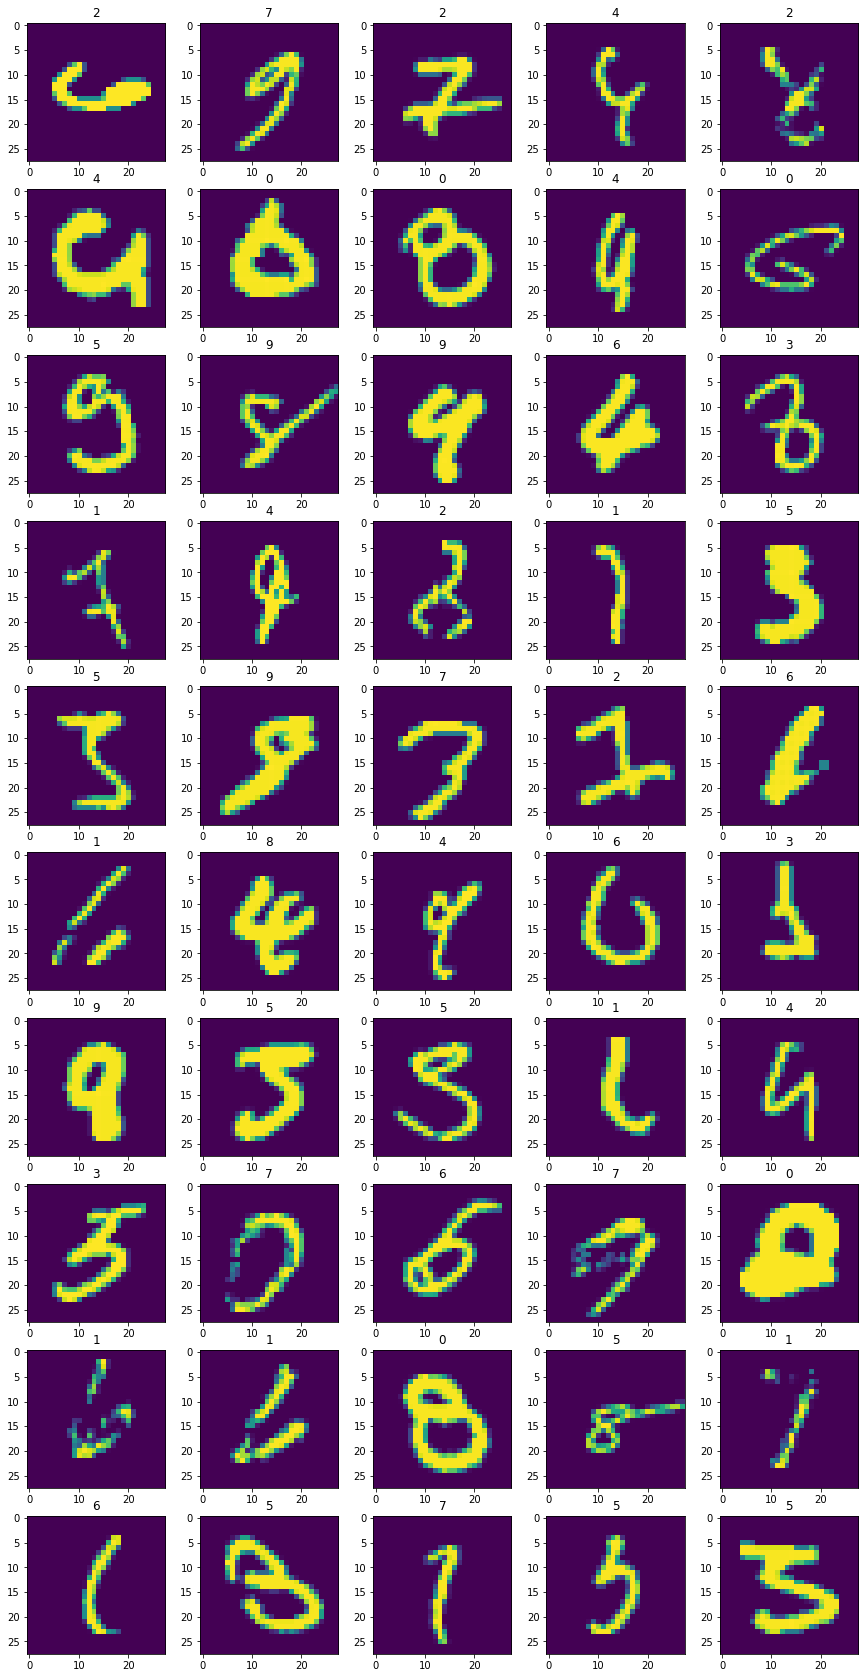

In [30]:
showImages(miss_data.view(-1, 28, 28).to(cpu), miss_predictions.to(cpu), figsize=(15, 30))